# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Camera Calibration
To correct distortion, we will calibrate the camera.  The following calibration follows the [OpenCV Camera Calibration tutorial](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html).
### Variable Initialization

In [1]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

nx, ny = (9, 6)

chessboard_imgs = glob.glob('./camera_cal/calibration*.jpg')

# arrays to store object points and image points from all images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image place

# prepare object points, like (0, 0, 0), ... (7, 5, 0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # x, y coords

### Calculate camera matrix and distortion coefficients

In [2]:
for fname in chessboard_imgs:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # if corners found, add object points, image points
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)  

# Calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

### Distortion Correction

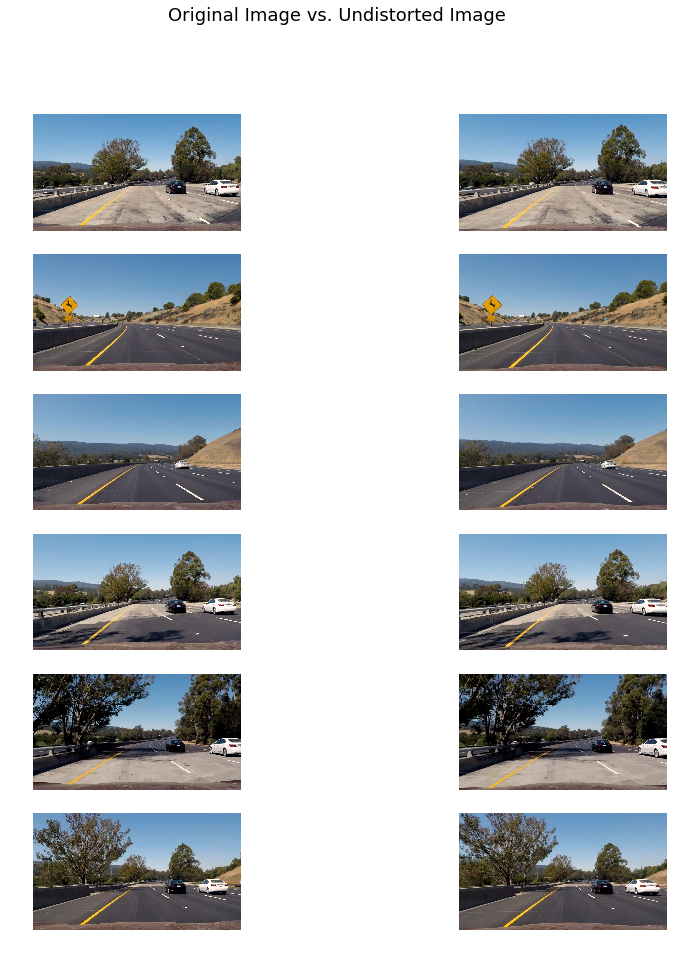

In [3]:
test_images = glob.glob('./test_images/test*.jpg')
fig, axarr = plt.subplots(len(test_images), 2) # two columns
fig.set_size_inches((14,15))
fig.suptitle('Original Image vs. Undistorted Image', fontsize=18)

calibrated_images = []
for idx, fname in enumerate(test_images):
    img = mpimg.imread(fname)

    dst = cv2.undistort(img, mtx, dist, None, mtx)

    calibrated_images.append(dst)

    axarr[idx, 0].imshow(img)
    axarr[idx, 1].imshow(dst) # show undistorted img in 2nd column
    axarr[idx, 0].axis('off')
    axarr[idx, 1].axis('off')
plt.show()

## Create Binary Thresholded Images
Using Sobel edge detection, and the red and saturation channels of each image (which detect white and yellow lines well), a binary image is created where each individual value described above is within some defined threshold.  Combined, lane lines (and other noise) are detected.

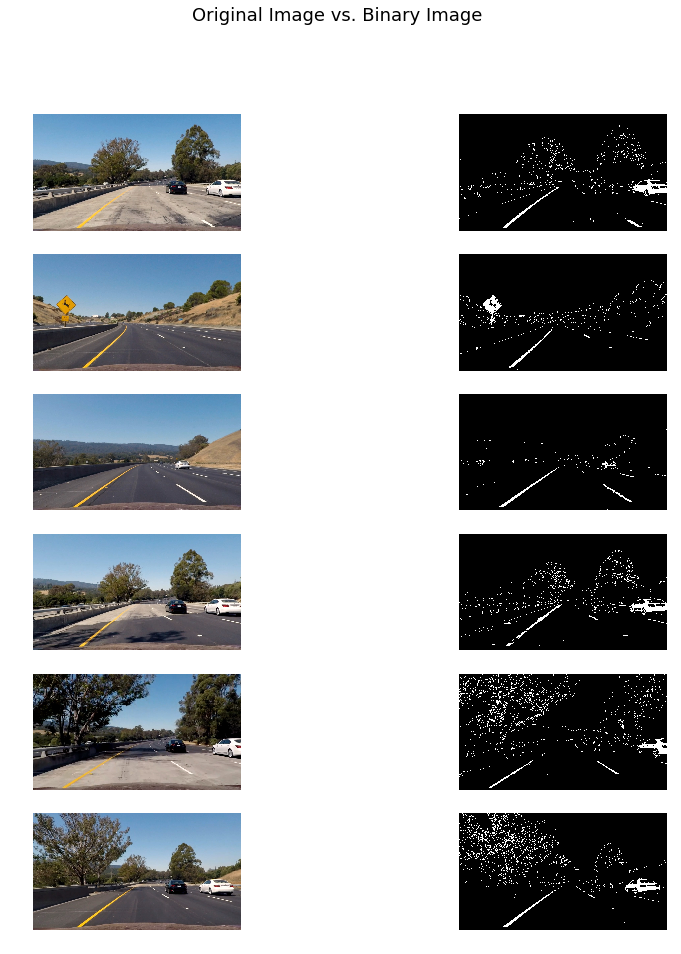

In [4]:
fig, axarr = plt.subplots(len(calibrated_images), 2) # two columns
fig.set_size_inches((14,15))
fig.suptitle('Original Image vs. Binary Image', fontsize=18)

binary_images = []
for idx, img in enumerate(calibrated_images):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobel_x = np.absolute(sobel_x) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))

    # Threshold x gradient
    sobel_thresh = (40, 100)
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    # extract red channel from RGB image
    R_channel = img[:, :, 0]
    # threshold to find lane-line pixels
    red_thresh = (220, 255)
    red_binary = np.zeros_like(R_channel)
    red_binary[(R_channel > red_thresh[0]) & (R_channel <= red_thresh[1])] = 1
    
    # extract saturation channel from HLS image
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S_channel = img_hls[:, :, 2]
    # threshold to find lane-line pixels
    sat_thresh = (205, 245)
    sat_binary = np.zeros_like(S_channel)
    sat_binary[(S_channel > sat_thresh[0]) & (S_channel <= sat_thresh[1])] = 1

    # combine all three images
    combined_binary = np.zeros_like(red_binary)
    combined_binary[(red_binary == 1) | (sat_binary == 1) | (sx_binary == 1)] = 1

    binary_images.append(combined_binary)

    axarr[idx, 0].imshow(img)
    axarr[idx, 1].imshow(combined_binary, cmap='gray') # show binary img in 2nd column
    axarr[idx, 0].axis('off')
    axarr[idx, 1].axis('off')

   ## Region of Interest
   There is a specific region of each image where lane lines are likely to be found.  This region is isolated while the other part of an image is ignored.

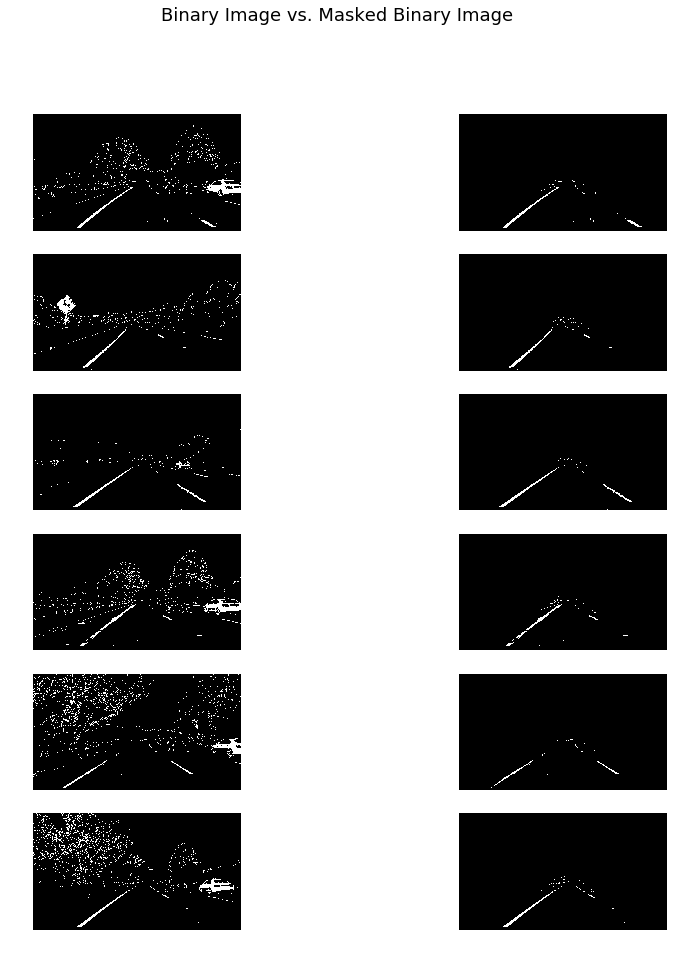

In [5]:
# Written in project 1
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

y_size = img.shape[0]

# create a region
bottom_left = (180, y_size)
top_left = (610, 390)
top_right = (710, 390)
bottom_right = (1180, y_size)
vertices = np.array([[bottom_left, top_left, top_right, bottom_right]])

fig, axarr = plt.subplots(len(binary_images), 2) # two columns
fig.set_size_inches((14,15))
fig.suptitle('Binary Image vs. Masked Binary Image', fontsize=18)

masked_images = []
for idx, binary_img in enumerate(binary_images):
    masked_img = region_of_interest(binary_img, vertices)
    masked_images.append(masked_img)

    axarr[idx, 0].imshow(binary_img, cmap='gray')
    axarr[idx, 1].imshow(masked_img, cmap='gray')
    axarr[idx, 0].axis('off')
    axarr[idx, 1].axis('off')
plt.show()

## Perspective Transform
A perspective transform is applied to the region above to obtain a "bird's eye view" to the lanes.  For a better idea of how perspective transform works, I will show a perspective transform done on the undistorted images.  Then, I will do a perspective transform on the masked binary images.

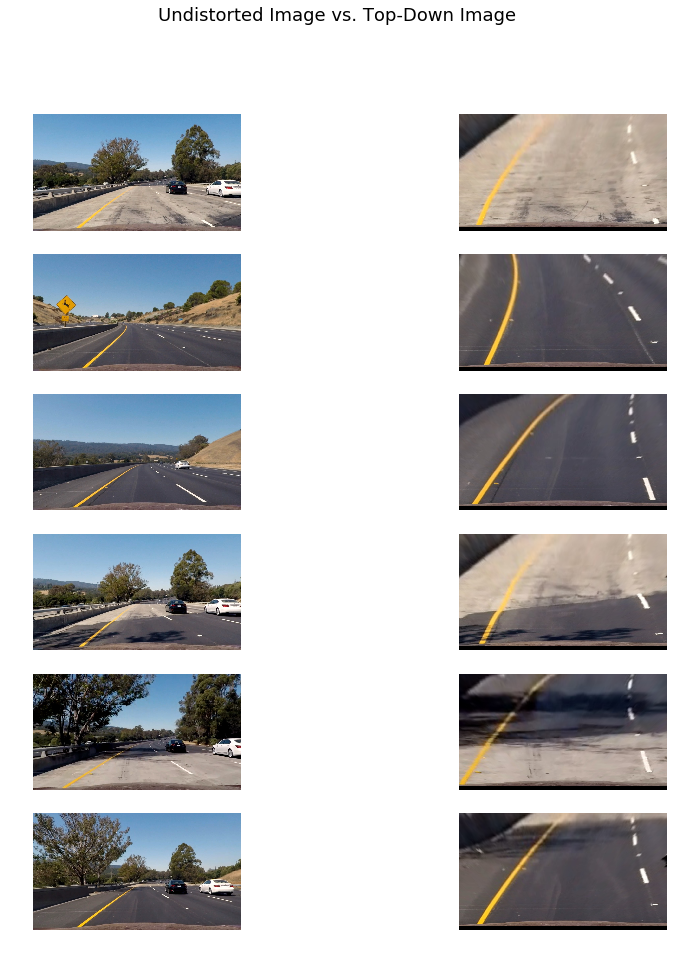

In [6]:
def perspective_warp(img):
    margin = 25
    x_size = img.shape[1]
    y_size = img.shape[0]

    src_bottom_left = (180, y_size)
    src_top_left = (510, 450)
    src_top_right = (760, 450)
    src_bottom_right = (1180, y_size)
    src_vertices = np.array([[src_bottom_left, src_top_left, src_top_right, src_bottom_right]])

    dst_bottom_left = [margin, y_size-margin]
    dst_top_left = [margin, margin]
    dst_top_right = [x_size-margin, margin]
    dst_bottom_right = [x_size-margin, y_size-margin]
    dst_vertices = np.array([[dst_bottom_left, dst_top_left, dst_top_right, dst_bottom_right]])

    src_points = np.float32(src_vertices)
    dst_points = np.float32(dst_vertices)
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))

    return warped
    

# warp and show perspective transform on undistorted images
fig, axarr = plt.subplots(len(calibrated_images), 2) # two columns
fig.set_size_inches((14,15))
fig.suptitle('Undistorted Image vs. Top-Down Image', fontsize=18)

for idx, calibrated_img in enumerate(calibrated_images):
    warped = perspective_warp(calibrated_img)
    
    axarr[idx, 0].imshow(calibrated_img)
    axarr[idx, 1].imshow(warped)
    axarr[idx, 0].axis('off')
    axarr[idx, 1].axis('off')
plt.show()

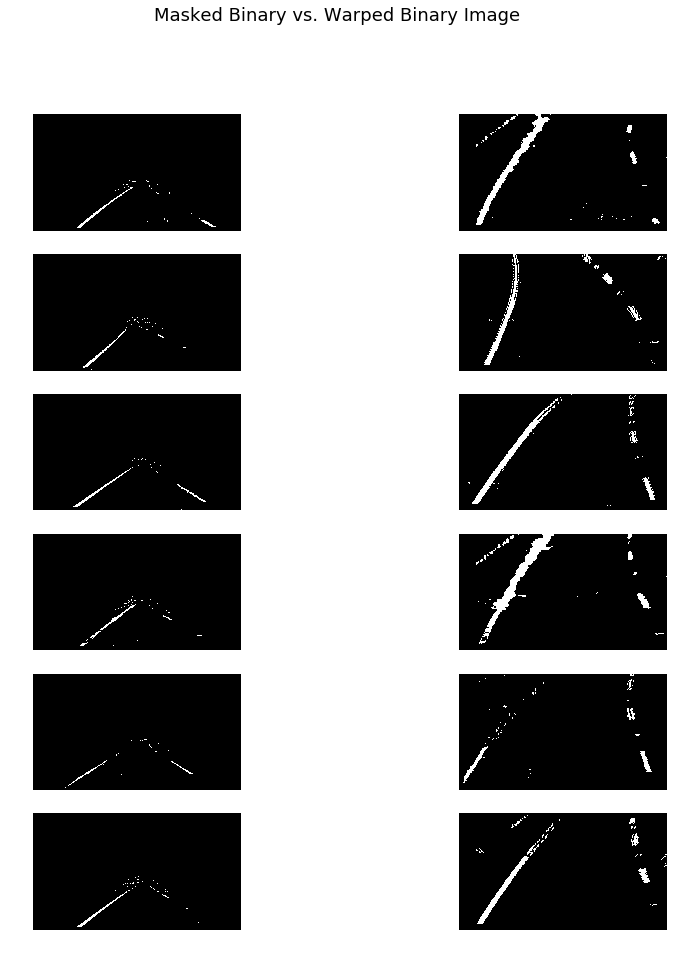

In [7]:
fig, axarr = plt.subplots(len(masked_images), 2) # two columns
fig.set_size_inches((14,15))
fig.suptitle('Masked Binary vs. Warped Binary Image', fontsize=18)

warped_images = []
for idx, masked_img in enumerate(masked_images):
    warped = perspective_warp(masked_img)
    warped_images.append(warped)
    
    axarr[idx, 0].imshow(masked_img, cmap='gray')
    axarr[idx, 1].imshow(warped, cmap='gray')
    axarr[idx, 0].axis('off')
    axarr[idx, 1].axis('off')
plt.show()

## Finding Lane Lines
To find lane lines, the base of the left and right lines must first be found.  To find the bases, a histogram of the pixel counts by image column is derived where the peaks represent the base of the lane lines.

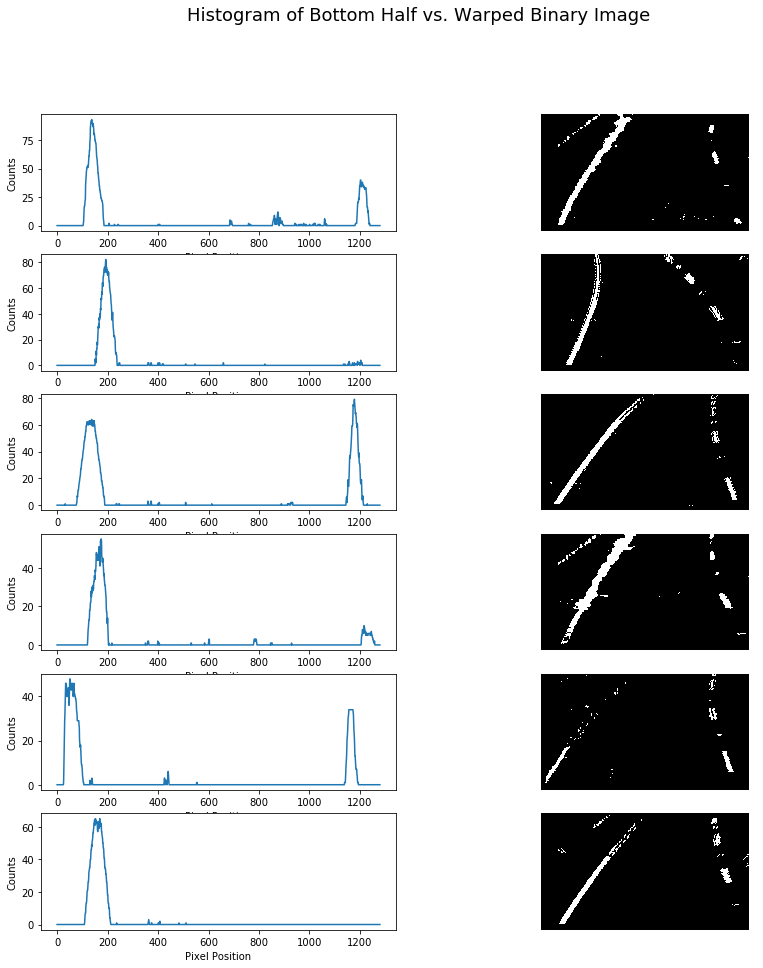

In [22]:
fig, axarr = plt.subplots(len(masked_images), 2) # two columns
fig.set_size_inches((14,15))
fig.suptitle('Histogram of Bottom Half vs. Warped Binary Image', fontsize=18)

for idx, warped_img in enumerate(warped_images):
    histogram = np.sum(warped_img[int(warped_img.shape[0]//1.25):, :], axis=0)

    axarr[idx, 0].plot(histogram)
    axarr[idx, 0].set_xlabel('Pixel Position')
    axarr[idx, 0].set_ylabel('Counts')
    axarr[idx, 1].imshow(warped_img, cmap='gray')
    axarr[idx, 1].axis('off')
plt.show()